## Якимански А В, задание 3

Задание: Выберите ряд из первого задания и постройте его модель ARIMA. Отчет нужно будет оформить в jupyter-ноутбук.
Дополнительное задание: попробуйте спрогнозировать график классическим ML.

In [1]:
import pandas as pd
import numpy as np
import tqdm

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt

from scipy.stats import boxcox
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

Возьмем ряд изменения среднемесячной температуры ("Mean monthly air temperature (Deg. F) Nottingham Castle")

In [2]:
series = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")['Deg']

In [3]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [4]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

Для проверки ряда на стационарность сделаем тест Дики-Фуллера и посмотрим на коррелограммы

Results of Dickey-Fuller Test:
Test Statistic                  -3.255492
p-value                          0.016989
#Lags Used                      14.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64


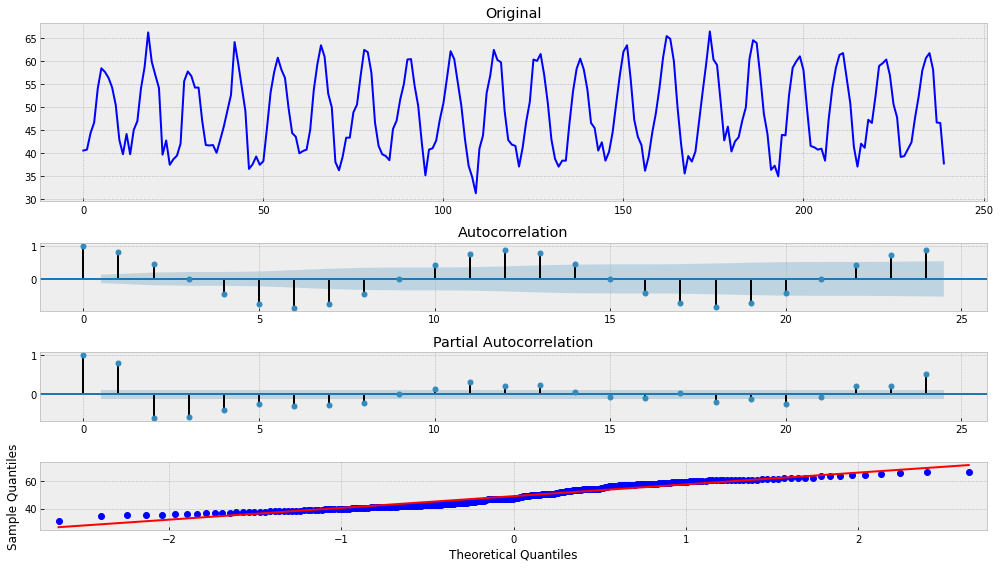

In [5]:
tsplot(series)

p-value меньше 0.05, но присутствует сезонность. Попробуем убрать её.

In [6]:
series = boxcox(series, 0)

In [7]:
series = series[12:] - series[:-12]

Повторно проверим преобразованный ряд на стационарность

Results of Dickey-Fuller Test:
Test Statistic                -6.411725e+00
p-value                        1.883599e-08
#Lags Used                     1.200000e+01
Number of Observations Used    2.150000e+02
Critical Value (1%)           -3.461136e+00
Critical Value (5%)           -2.875079e+00
Critical Value (10%)          -2.573986e+00
dtype: float64


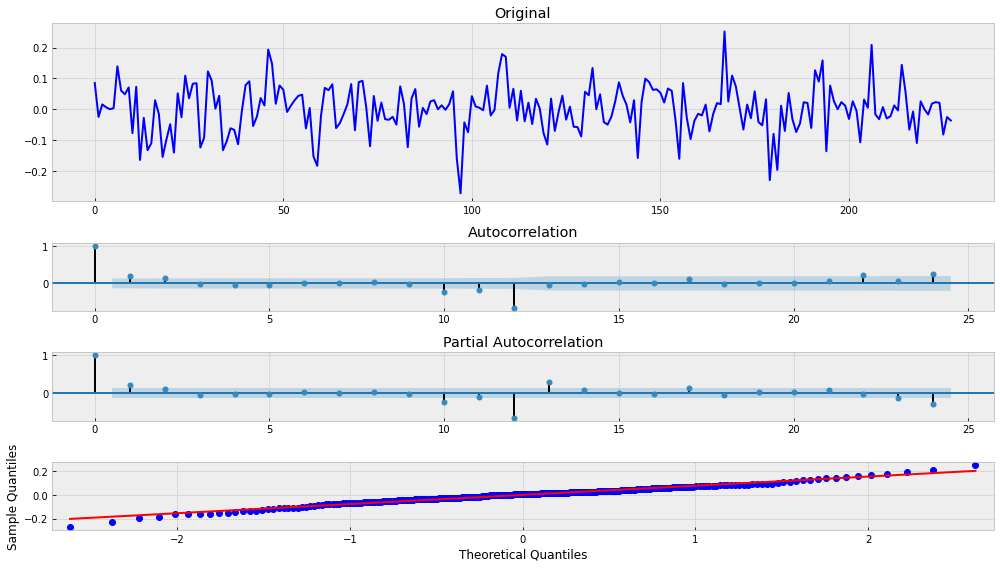

In [8]:
tsplot(series)

Мы видим, что p-value снизилось почти до нуля, сезонность ушла. Ряд стал стационарным. Попробуем построить модель ARIMA.

In [9]:
# скроем вывод предупреждений
import warnings
warnings.filterwarnings('ignore')

aic: -552.84902 | order: (4, 0, 3)
Results of Dickey-Fuller Test:
Test Statistic                  -5.338424
p-value                          0.000005
#Lags Used                      15.000000
Number of Observations Used    212.000000
Critical Value (1%)             -3.461578
Critical Value (5%)             -2.875272
Critical Value (10%)            -2.574089
dtype: float64


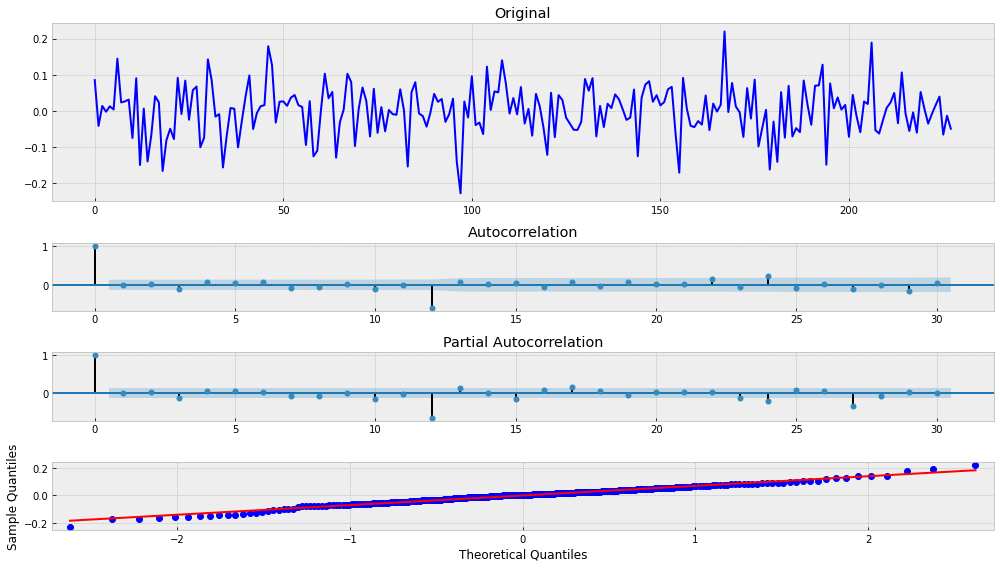

In [10]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


tsplot(best_mdl.resid, lags=30)

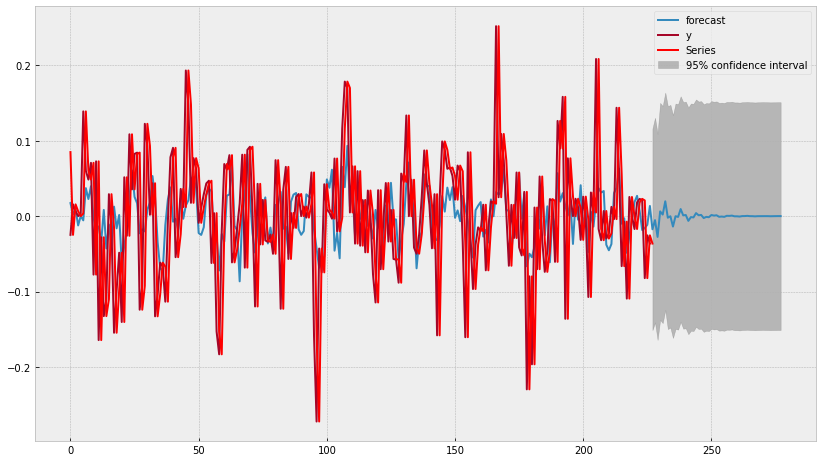

In [11]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    best_mdl.plot_predict(1, len(series)+50, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

Модель, по всей видимости, переобучилась на реальных данных. Возможно, так получилось из-за предварительного преобразования ряда в стационарный. Попробуем обучить модель ARIMA на изначальном ряде.

In [12]:
# повторно загрузим исходный (нестационарный) ряд
series = pd.read_csv("mean-monthly-air-temperature-deg.csv")['Deg']

aic: 1146.70169 | order: (2, 1, 4)
Results of Dickey-Fuller Test:
Test Statistic                  -5.376083
p-value                          0.000004
#Lags Used                       9.000000
Number of Observations Used    229.000000
Critical Value (1%)             -3.459233
Critical Value (5%)             -2.874245
Critical Value (10%)            -2.573541
dtype: float64


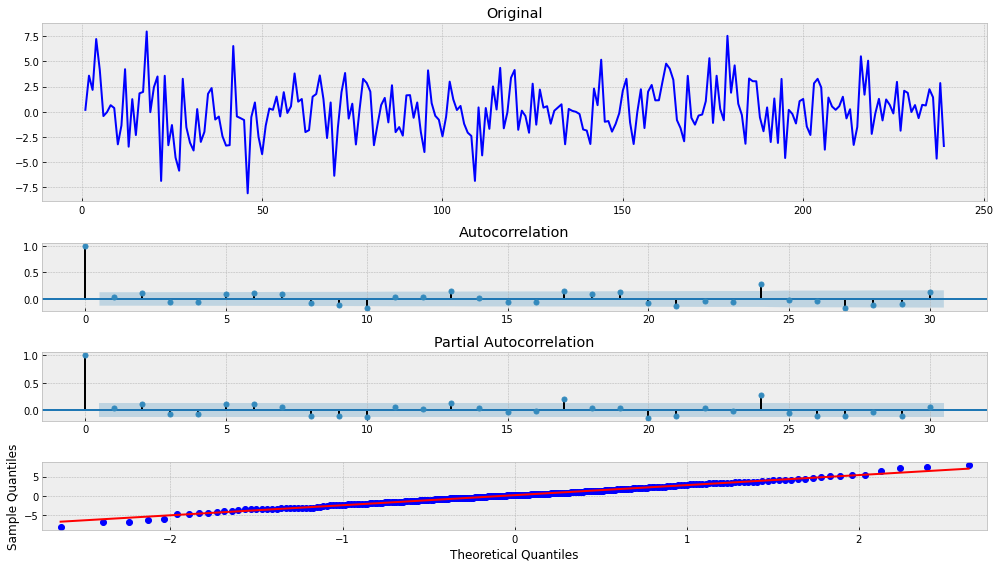

In [13]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


tsplot(best_mdl.resid, lags=30)

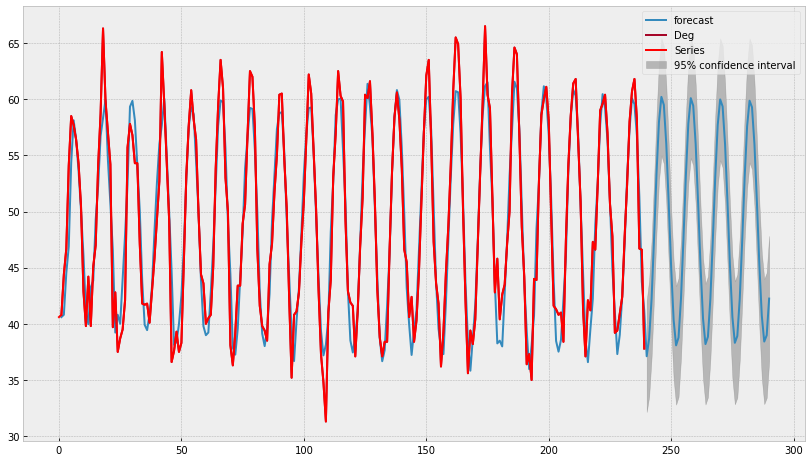

In [14]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    best_mdl.plot_predict(1, len(series)+50, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

Прогноз похож на фактические данные, использованные для обучения, при этом находится в доверительном интервале (95%). Можно сделать вывод, что модель ARIMA не требует предварительного приведения ряда к стационарности.

Теперь построим модель предсказаний значений временного ряда, используя методы "классического" ML. 

In [15]:
from sklearn.linear_model import LinearRegression

In [16]:
series.head()

0    40.6
1    40.8
2    44.4
3    46.7
4    54.1
Name: Deg, dtype: float64

In [17]:
# определим функцию подготовки данных и разбивки на трейн- и тест-выборку
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    
    
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Deg.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
     
    
    X_train = data.loc[:test_index].drop(["Deg"], axis=1)
    y_train = data.loc[:test_index]["Deg"]
    X_test = data.loc[test_index:].drop(["Deg"], axis=1)
    y_test = data.loc[test_index:]["Deg"]
    
    return X_train, X_test, y_train, y_test

In [18]:
X_train, X_test, y_train, y_test = prepareData(series, lag_start=1, lag_end=20, test_size=0.3)

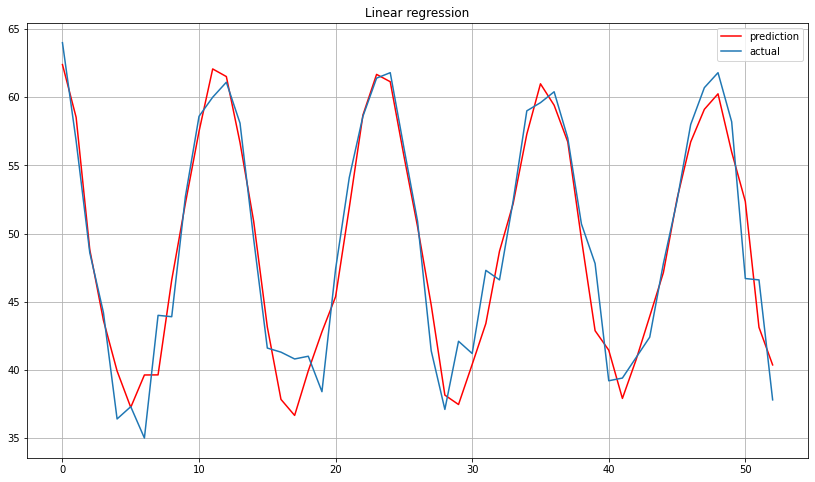

In [19]:
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

In [20]:
lr.score(X_test, y_test)

0.9223020069855583

Судя по хорошему приближению графиков факт/предсказание и достаточно высокому скору (0.92), модель линейной регрессии обучилась неплохо.